In [14]:
!rm -rf cv-image-classification
!git clone https://github.com/AlexFerroni02/cv-image-classification.git

Cloning into 'cv-image-classification'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 15 (delta 1), reused 12 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 1.98 MiB | 34.36 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [15]:
import sys
sys.path.append("/content/cv-image-classification")

# Error Analysis and Model Interpretation

The purpose of this notebook is to analyze the errors made by the trained
baseline CNN model.

Rather than focusing on improving accuracy, this analysis aims to:
- Identify systematic failure modes
- Understand class-level confusion
- Inspect misclassified examples
- Gain insights into model limitations


In [16]:
# Core libraries
import torch
import numpy as np
import matplotlib.pyplot as plt

# Evaluation utilities
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Dataset and model
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from src.model import SimpleCNN


In [17]:
import sys
sys.path.append("/content/cv-image-classification")

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and load trained weights
model = SimpleCNN(num_classes=10).to(device)
model.load_state_dict(torch.load("/content/cv-image-classification/results/baseline_model.pth", map_location=device))
model.eval()

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [18]:
# Same transformation used during training
transform = transforms.ToTensor()

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

class_names = test_dataset.classes


100%|██████████| 170M/170M [00:03<00:00, 44.5MB/s]


In [19]:
# Collect predictions

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


## Confusion Matrix

A confusion matrix provides a class-wise view of model performance.
It helps identify which classes are frequently confused with each other,
revealing systematic errors rather than isolated mistakes.


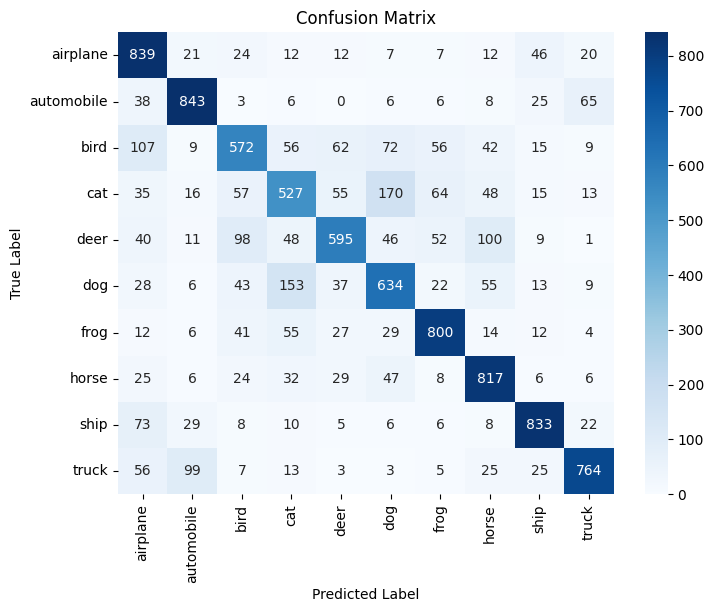

In [20]:
# Confusion matrix COde

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Confusion Matrix Insights

From the confusion matrix, we can observe that:
- Visually similar classes (e.g., cat vs dog) are often confused
- Vehicle classes are generally easier to classify
- Some classes exhibit asymmetric confusion patterns

These patterns suggest that the model relies heavily on coarse visual cues.


In [21]:
# Collect misclassified examples
misclassified = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(images.size(0)):
            if preds[i] != labels[i]:
                misclassified.append(
                    (images[i].cpu(), labels[i].item(), preds[i].item())
                )


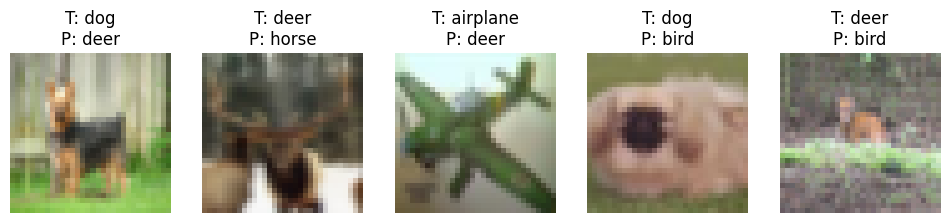

In [22]:
def show_misclassified(samples, num_images=5):
    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        img, true_label, pred_label = samples[i]
        img = img.permute(1, 2, 0)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"T: {class_names[true_label]}\nP: {class_names[pred_label]}")
        plt.axis("off")
    plt.show()

show_misclassified(misclassified, num_images=5)


## Error Patterns

By visually inspecting misclassified samples, we notice that:
- Objects may be partially occluded or small
- Background context sometimes dominates predictions
- Low resolution limits discriminative details

These errors are consistent with the dataset characteristics observed
during the exploration phase.


## Model Interpretability (Grad-CAM)

Grad-CAM can be used to visualize which regions of the image contribute
most to the model's predictions.

This helps assess whether the model focuses on meaningful object regions
or spurious background patterns.


## Error Analysis Conclusions

The error analysis highlights that the baseline CNN:
- Learns meaningful but coarse visual representations
- Struggles with fine-grained distinctions between similar classes
- Is sensitive to background clutter and object scale

These insights motivate future improvements such as:
- Data augmentation
- Regularization
- Deeper architectures

Importantly, the observed failure modes are expected given the simplicity
of the baseline model and the low resolution of the dataset.
